In [11]:
from typing import List,Dict , TypedDict, Annotated
from langgraph.graph import StateGraph, END, START
from dotenv import load_dotenv  
from langchain_google_genai import ChatGoogleGenerativeAI  
from pydantic import BaseModel, Field  
import operator

In [3]:
load_dotenv()
import os
google_gemini_api_key = os.getenv("api_key")

In [4]:
model=ChatGoogleGenerativeAI(model="gemini-2.5-flash",temperature=0.3,api_key=google_gemini_api_key)

In [5]:
class evalschema(BaseModel):
    feedback:str=Field(description="Feedback on the response generated by the model"),
    score:int=Field(description="Score for the response generated by the model, on a scale of 1 to 10")


In [6]:
structured_model= model.with_structured_output(evalschema)

c:\Users\HP\Desktop\Gen_ai\env\Lib\site-packages\pydantic\json_schema.py:2448: PydanticJsonSchemaWarning: Default value (FieldInfo(annotation=NoneType, required=True, description='Feedback on the response generated by the model'),) is not JSON serializable; excluding default from JSON schema [non-serializable-default]
  warnings.warn(message, PydanticJsonSchemaWarning)


In [7]:
essay="""Medical ethics is the moral framework guiding healthcare professionals in making fair, compassionate, and responsible decisions. It is built on core principles such as autonomy, beneficence, non-maleficence, and justice. Autonomy respects a patient’s right to make informed choices, while beneficence ensures actions are taken for the patient’s well-being. Non-maleficence emphasizes “do no harm,” and justice promotes fairness in treatment. In today’s world of rapid medical advancements, ethical considerations help balance technology with humanity. Upholding medical ethics fosters trust between doctors and patients, ensuring that care is not only effective but also respectful, dignified, and morally sound."""

In [10]:
prompt=f"Evaluate the following essay on medical ethics and provide feedback and a score out of 10:\n\n{essay}"
structured_model.invoke(prompt).score

7

In [15]:
class UPSCstate(TypedDict):
    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float

In [21]:
def eval_lang(state:UPSCstate):
    prompt=f"Evaluate the language used in the following essay and provide a feedback and assign  a score out of 10:\n\n{state['essay']}"
    output=structured_model.invoke(prompt)
    return {'language_feedback':output.feedback,'individual_scores':[output.score]}

In [17]:
def eval_analysis(state:UPSCstate):
    prompt=f"Evaluate the depth of  analysis in the following essay and provide a feedback and assign  a score out of 10:\n\n{state['essay']}"
    output=structured_model.invoke(prompt)
    return {'analysis_feedback':output.feedback,'individual_scores':[output.score]}

In [18]:
def eval_thought(state:UPSCstate):
    prompt=f"Evaluate the clarity of thought in the following essay and provide a feedback and assign  a score out of 10:\n\n{state['essay']}"
    output=structured_model.invoke(prompt)
    return {'clarity_feedback':output.feedback,'individual_scores':[output.score]}

In [19]:
def final_eval(state:UPSCstate):
   prompt=f"Based on the following feedback and scores, provide a summarized feedback and language Feedback: {state['language_feedback']}\nAnalysis Feedback: {state['analysis_feedback']}\nClarity Feedback: {state['clarity_feedback']}\nIndividual Scores: {state['individual_scores']}"
   overall_feedback=model.invoke(prompt)
   

   avg_score=sum(state['individual_scores'])/len(state['individual_scores'])
   return {'overall_feedback':overall_feedback,'avg_score':avg_score}

In [24]:
#adding node
graph=StateGraph(UPSCstate)
graph.add_node("evaluate_language",eval_lang)
graph.add_node("evaluate_analysis",eval_analysis)
graph.add_node("evaluate_thought",eval_thought)
graph.add_node("final_eval",final_eval)

In [25]:
#adding edges 
graph.add_edge(START,"evaluate_language")
graph.add_edge(START,"evaluate_analysis")
graph.add_edge(START,"evaluate_thought")

graph.add_edge("evaluate_language","final_eval")
graph.add_edge("evaluate_analysis","final_eval")
graph.add_edge("evaluate_thought","final_eval")
#executing the graph
graph.add_edge('final_eval',END)
workflow=graph.compile()

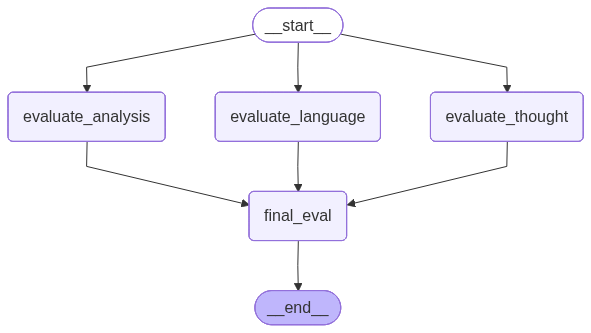

In [26]:
workflow

In [27]:
inital_state={
    "essay":essay
}
workflow.invoke(inital_state)

{'essay': 'Medical ethics is the moral framework guiding healthcare professionals in making fair, compassionate, and responsible decisions. It is built on core principles such as autonomy, beneficence, non-maleficence, and justice. Autonomy respects a patient’s right to make informed choices, while beneficence ensures actions are taken for the patient’s well-being. Non-maleficence emphasizes “do no harm,” and justice promotes fairness in treatment. In today’s world of rapid medical advancements, ethical considerations help balance technology with humanity. Upholding medical ethics fosters trust between doctors and patients, ensuring that care is not only effective but also respectful, dignified, and morally sound.',
 'language_feedback': "The language used in the essay is exceptionally clear, concise, and professional. It effectively defines complex terms like autonomy, beneficence, non-maleficence, and justice in an accessible manner. The flow is logical, and the essay successfully co